# Why we use log returns for stock returns

## Python simulations, convexity corrections and lots of pretty graphs

When looking at modelling stock prices it is almost taken as given that the idea is to model 'log returns'. Despite being a fundamental of asset price modelling sometimes it's nice (we all have our kicks) to understand exactly how we got here by working through exactly what the statistical implications are of this approach. The aim is to do the following:
 - examine the concepts of simple and log return
 - build these up to multi-period ideas
 - add randomness
 - again, build these up to multi-period ideas

all in an effort to tease out exactly why log returns are the preferred way to model stock returns.

## 'Simple' Return

Let's start by defining exactly what we learned in school as percentage change:

$$ r_t = \frac{S_t - S_{t-1}}{S_{t-1}} $$

where we have:
 - `r_t` as the 'simple' return for period `t`
 - `S_t` as the stock price at time period `t`

So if we have a previous stock price of `100` and a new one of `110`, then we have `(110 - 100) / 100` = `10 / 100` = `10%`. We can then rearrange this expression so that we have a 'model' for what a stock price should be in a future period of time:

$$ S_t = S_{t-1} [1 + r_t] $$

So if we define `r = 9.00%` then we get from a starting price of `100` the new price of `109`. So far, so 'simple'.

## What happens when we want to have multiple periods?

So the above shows us how we can model the next price from the previous price. What if we want to model the price a few periods down the line? Well for `T` periods we can write the following where:
 - we assume that `r` is defined over the whole period `T`, and so one period has an `r` of `r/T`
 - we have assumed that `r` is constant and so equal in all time periods

$$
\begin{align}
S_T &= S_{T-1} [1 + \frac{r}{T}] \\
    &= S_{T-2} [1 + \frac{r}{T}]^2 \\
    & \ldots \\
    &= S_0 [1 + \frac{r}{T}]^T
\end{align}
$$

So how does this look? Let's now do the following - if we want to model a stock having a `r = 9.00%` simple return over a period let's see how our final price compares to our initial price if we keep breaking that period down into smaller chunks.

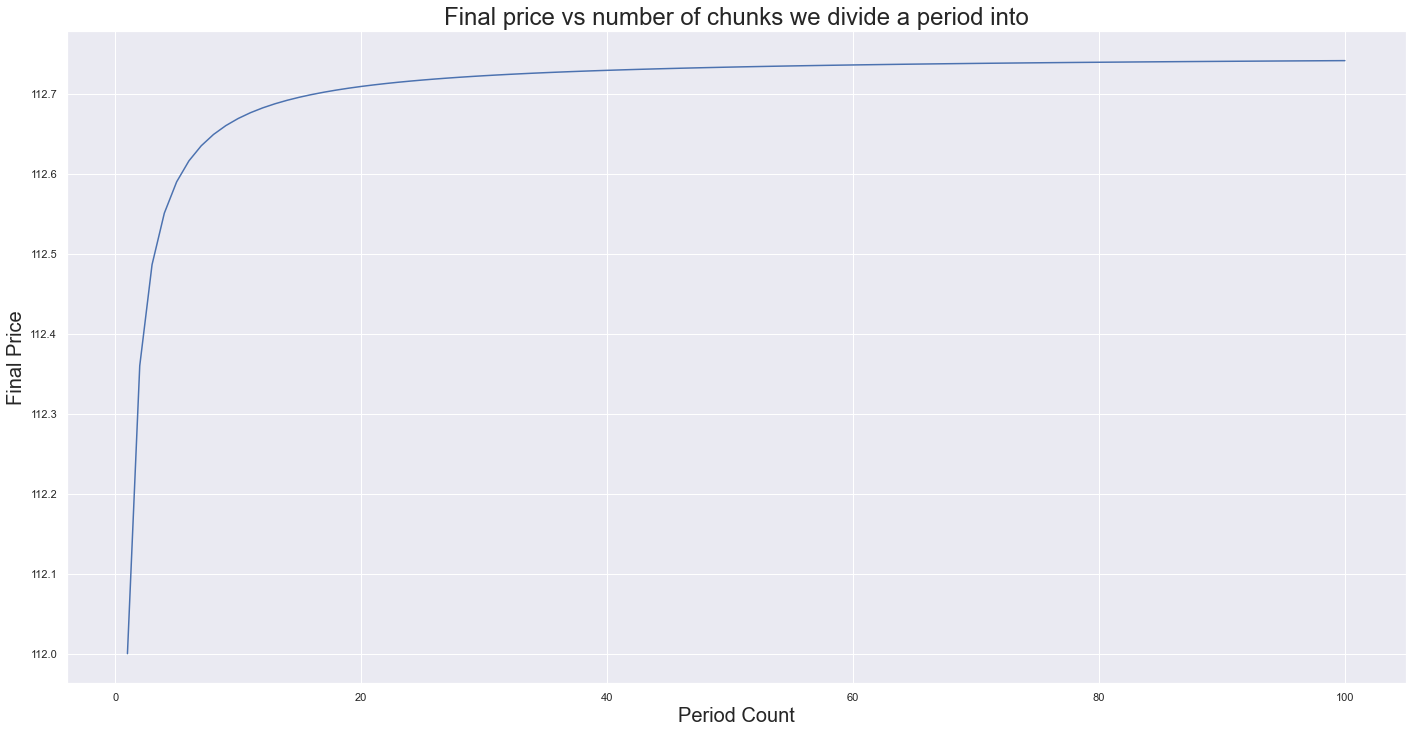

In [17]:
# import the usual suspects
import datetime as dt
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

# mpl.rcParams['agg.path.chunksize'] = 1000000
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set()

# define our selection of chunks to split the period into
chunks = [x for x in range(1, 101)]
# define initial price, simple return
s0 = 100
r_s = 0.12
# define our final prices
sT = [s0*(1+r_s/x)**x for x in chunks]

# plot them
fig, ax = plt.subplots(figsize=(24,12))

ax.plot(chunks, sT)
ax.set_title('Final price vs number of chunks we divide a period into', fontsize=24)
ax.set_xlabel('Period Count', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);

__So it seems like the final price we get will depend on how many periods we sub-divide our chosen time frame into.__ This isn't really all that great as it means that the return we get is tied to the time horizon we use to define our return e.g. if we define our return (as we have done) as 12.00% for a full period e.g. a year, then when looking at a period of 1 month we will not get a return of 1.00%. Instead to accomplish 12.00% over a 1 year time frame we would need to have the following 1 month returns:

$$ \frac{S_T}{S_0} = 1.12 = (1 + r)^{12} $$

which gives monthly returns of:

$$ r = [1 + 0.12]^{\frac{1}{12}} - 1 = 0.9489\% $$

## What number does it seem to be approaching?

So in the above chart it appears like after around 40 sub-divisions we seem to be getting close to approach a limit - what is it? It turns out that the above expression in the limit (as the number of sub-divisions heads to infinity) tends toward the ['exponential function'](https://en.wikipedia.org/wiki/Exponential_function) i.e.

$$
\begin{align}
S_T &= S_0 [1 + \frac{r}{T}]^T \\
\lim_{T \to \infty} S_T &= S_0 e^{r} \\
\end{align}
$$

We can see this when we re-draw the above chart but with a horizontal line included for this limit.

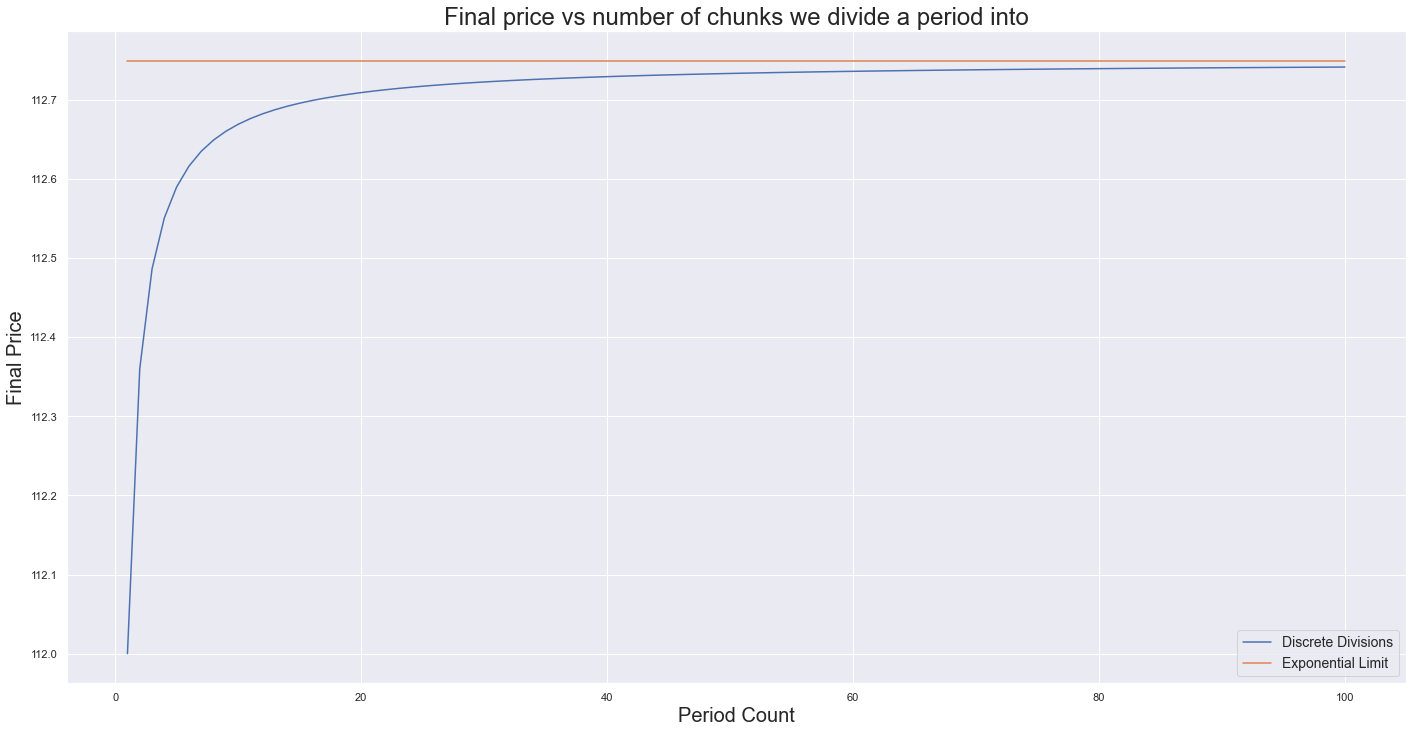

In [18]:
# plot them
fig, ax = plt.subplots(figsize=(24,12))

ax.plot(chunks, sT, label='Discrete Divisions')
ax.plot(chunks, [s0*np.exp(r_s) for x in chunks], label='Exponential Limit')
ax.set_title('Final price vs number of chunks we divide a period into', fontsize=24)
ax.set_xlabel('Period Count', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20)
ax.legend(fontsize=14);

## Why does this happen?

Put into words, the above says the following - when we sub-divide a 'discrete' time step into an infinite number of infinitely small steps we end up with the exponential function as an upper limit. Why?

__Compounding__. The exponential function is all about compounding and when we divide a change into smaller and smaller sequential time steps - then previous changes will impact future changes. We can again see this graphically by comparing a straight 'linear' return e.g. 1% every month vs the compounded one.

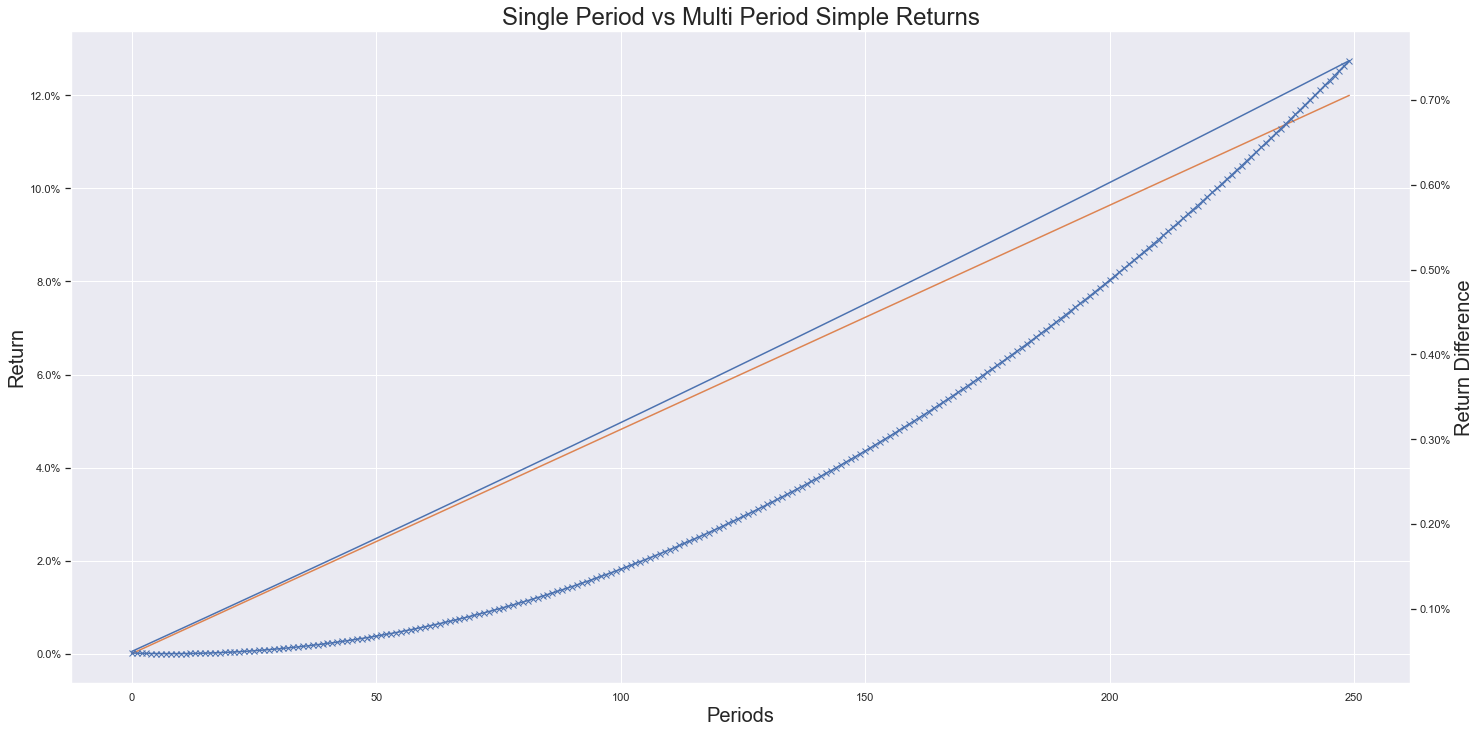

In [19]:
# define simple returns and compounded returns
single_period_rets = np.linspace(0, 1, 250) * r_s
multi_period_rets = np.cumprod([1+r_s/250 for x in range(1,251)]) - 1

# plot them
fig, ax = plt.subplots(figsize=(24,12))
ax2 = ax.twinx()

ax.plot([x for x in range(0, 250)], multi_period_rets)
ax.plot([x for x in range(0, 250)], single_period_rets)
ax2.plot([x for x in range(0, 250)], multi_period_rets - single_period_rets, marker='x')
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()])
ax2.set_yticklabels(['{:,.2%}'.format(x) for x in ax2.get_yticks()])
ax2.grid(None)

ax.set_title('Single Period vs Multi Period Simple Returns', fontsize=24)
ax.set_xlabel('Periods', fontsize=20)
ax.set_ylabel('Return', fontsize=20)
ax2.set_ylabel('Return Difference', fontsize=20);

So we have this criss-cross line that shows the compounding effect over multiple periods that eventually accounts for the ~0.70% difference between `12%` and `exp(0.12) = 12.749%`. So can we use this to re-define returns?

## 'Log' Returns

If we use the above and are comfortable with the idea that we move to infinitely small steps with infinitely many periods, then yes - we can re-arrange the above formula to get:

$$
\begin{align}
S_T &= S_0 e^{r} \\
  \frac{S_T}{S_0} &= e^{r} \\
  ln(\frac{S_T}{S_0}) &= {r}
\end{align}
$$

which we will call 'log returns' as the return r is defined as the log of the price ratio between final and start prices. So the next question becomes:

## Does this solve our problem of different return numbers for different time periods?

Let's go again with this one. If we rearrange to define our price series as:

$$ S_t = S_{t-1} e^{\frac{r}{T}} $$

then we can get an idea of how to get a price after a few steps:

$$
\begin{align}
S_T &= S_0 [e^{\frac{r}{T}}] [e^{\frac{r}{T}}] \ldots [e^{\frac{r}{T}}] \\
    &= S_0 e^{\frac{r}{T} + \ldots + \frac{r}{T}} \\
    &= S_0 e^{r}
\end{align}
$$

So at least algebraically it looks like we check out as our returns are 'additive'. This can be rephrased as the following:

$$
\begin{align}
r_T &= ln(\frac{S_T}{S_0}) \\
      &= ln(\frac{S_T}{S_{T-1}}) + ln(\frac{S_{T-1}}{S_{T-2}}) + \ldots + ln(\frac{S_1}{S_{0}}) \\
      &= r_{T-1} + r_{T-2} + \ldots + r_0
\end{align}
$$

where the additive property of logs has been leveraged. Now re-plotting our previous graph to compare the returns if we sub-divide our period into different numbers of sub-divisions:

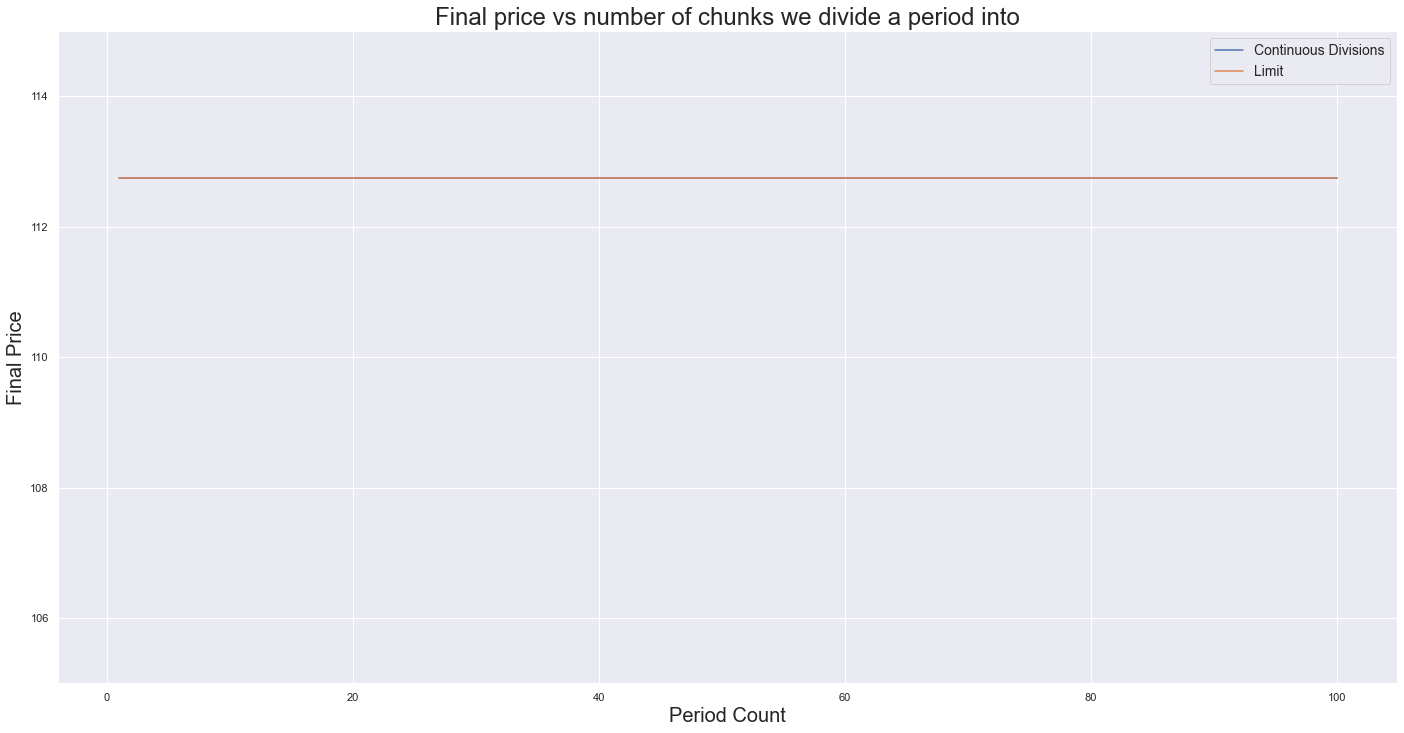

In [20]:
# plot them
fig, ax = plt.subplots(figsize=(24,12))

ax.plot(chunks, [s0*np.exp(r_s/x)**x for x in chunks], label='Continuous Divisions')
ax.plot(chunks, [s0*np.exp(r_s) for x in chunks], label='Limit')
ax.set_title('Final price vs number of chunks we divide a period into', fontsize=24)
ax.set_xlabel('Period Count', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20)
ax.set_ylim(105,115)
ax.legend(fontsize=14);

So yes - it solves our problem of having different returns over a full period based on if we break down that period into smaller chunks. This is great.

## Introducing: Randomness

So far all we have looked at is the properties of deterministic time series - there has been no randomness just a fixed rate of return, `r`. Now let's add some randomness into the picture to reflect the fact that stock prices don't just move rigidly in straight lines. To do this, let's return to our simple model again of a single time period and work our way back up.

## Simple Returns with randomness

Let's forget the fact that we have established the problem with simple returns being not time period homogenous and re-define our stock price 'model' as:

$$
\begin{align}
r_t &= \frac{S_t - S_{t-1}}{S_{t-1}} \\
      &= \frac{r}{T} + \frac{\sigma}{\sqrt{T}}\epsilon_t \ \ \ \  \epsilon_t \sim N(0,1)
\end{align}
$$

There's a lot to take in here but in essence what we have defined is that instead of our simple return being just a fixed change, we have:
 - a fixed component `r` that remains from above
 - a new variable component, `epsilon`, that follows a standard normal distribution and is scaled up and down by a scaling parameter, `sigma`, depending on how volatile we want the stock to be

The normal distribution assumption is significant but useful for now as it allows us to use standard deviation as a complete measure of dispersion as 'higher order moments are zero' i.e. once we know standard deviation we don't need any more info about the distribution to characterise its spread (like skew or kurtosis).

## What's going on with that square root of T bit?

This is the idea that variance is linear. If we define our standard deviation as a measure over the full time period (i.e full year as is commonly done with annualisation), then we need a way to chunk this _annual_ deviation down into smaller chunks (like _daily_ deviations). To do this we have the following:

$$
\begin{align}
Var(\epsilon + \epsilon + \ldots + \epsilon) &= Var(T \epsilon) \\
 &= T * Var(\epsilon) \\
\end{align}
$$

And so for standard deviation we get the following:

$$
\begin{align}
STD() &= \sqrt{Var()} \\
     &= \sqrt{T * Var(\epsilon)} \\
     &= \sqrt{T} * STD(\epsilon) \\
\end{align}
$$

## Can we plot this using Python?

So now we have an idea of what our returns _should_ look like, let's run a few 'simulations' to see if this plays out in the data. To create our random numbers we will use NumPy - if you're curious about what is happening under the hood here I've written an intuitive explainer [here](https://towardsdatascience.com/where-does-python-get-its-random-numbers-from-81dece23b712).

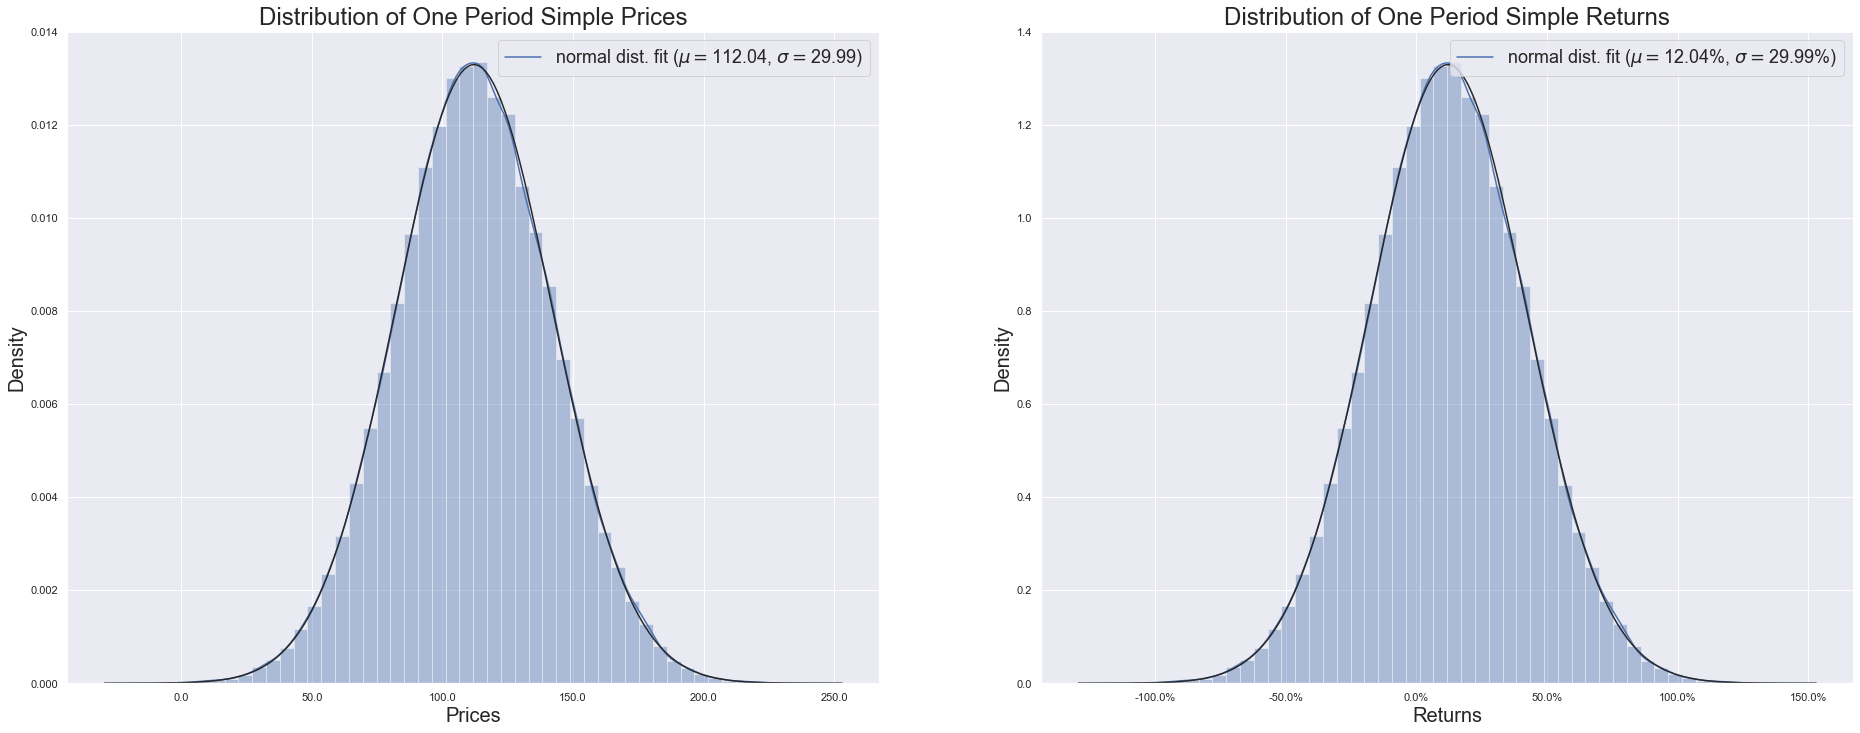

In [5]:
# set starting stock price, retun, std dev and days per year
s0 = 100
r = 0.12
sigma = 0.30
paths = 100000

# set up numpy PCG PRNG
rng = np.random.default_rng(seed=123)
norm_draws = rng.normal(size=paths)

# compute our end of (single) period prices
simp_one_period_prices = [s0 * (1 + r) + s0 * x * sigma for x in norm_draws]
# compute simple returns based on final prices
simp_one_period_rets = [(x - s0)/s0 for x in simp_one_period_prices]

# plot the distribution of final prices
# create the figure
fig, ax = plt.subplots(ncols=2, figsize=(32,12))

# fit a dist plot
sns.distplot(simp_one_period_prices, fit=stats.norm, ax=ax[0]);
sns.distplot(simp_one_period_rets, fit=stats.norm, ax=ax[1]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(simp_one_period_prices)
ax[0].set_title('Distribution of One Period Simple Prices', fontsize=24)
ax[0].set_xlabel('Prices', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2f}, $\sigma=${1:,.2f})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(simp_one_period_rets)
ax[1].set_title('Distribution of One Period Simple Returns', fontsize=24)
ax[1].set_xlabel('Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

In [6]:
print("Negative prices: {}".format(', '.join([str(round(x, 2)) for x in sorted(simp_one_period_prices) if x < 0])))

Negative prices: -20.53, -7.01, -5.67, -4.86, -2.38, -1.95, -1.65, -1.28, -0.34


So how does this look:
 - we have a mean final price of 112 which lines up with what we inputted - a mean return of 12%
 - the distribution of final prices and returns is incredibly 'normal'
 - the standard deviation of the returns is exactly 30% which is what we entered

However we have a very clear problem - __we have negative prices for some large negative deviations__. We will address this, but first let's see if we also have the problem we had for non-random simple returns when we moved from single to multi-period: that the return depended on how many periods you divided it into.

## Multi Period Simple Returns with Randomness

Let's augment what we had before to now include our randomness:

$$ S_{t} = S_{t-1} [1 + r/T + \frac{\sigma}{\sqrt{T}} \epsilon_t] $$

and so we define our final price as:

$$ S_T = S_0 \prod_{t=1}^{T} [1 + r/T + \frac{\sigma}{\sqrt{T}} \epsilon_t] $$

We can see here again that if we remove the randomness and let the time periods become infinitely short (and their count infinite), then we head towards the geometric return:

$$
\begin{align}
S_T &= S_0 (1 + r/T)^T \\
\lim_{T \to \infty} S_T &= S_0 e^r
\end{align}
$$

The issue here is that __the random numbers make the return each period different__ and so we have the product sign rather than taking the exponent. Let's see if we get a mean return that is closer to the exponential return when we sub-divide our period.

Let's sub-divide into 250 parts to represent roughly the 250 trading days of a year and then plot the paths we have generated:

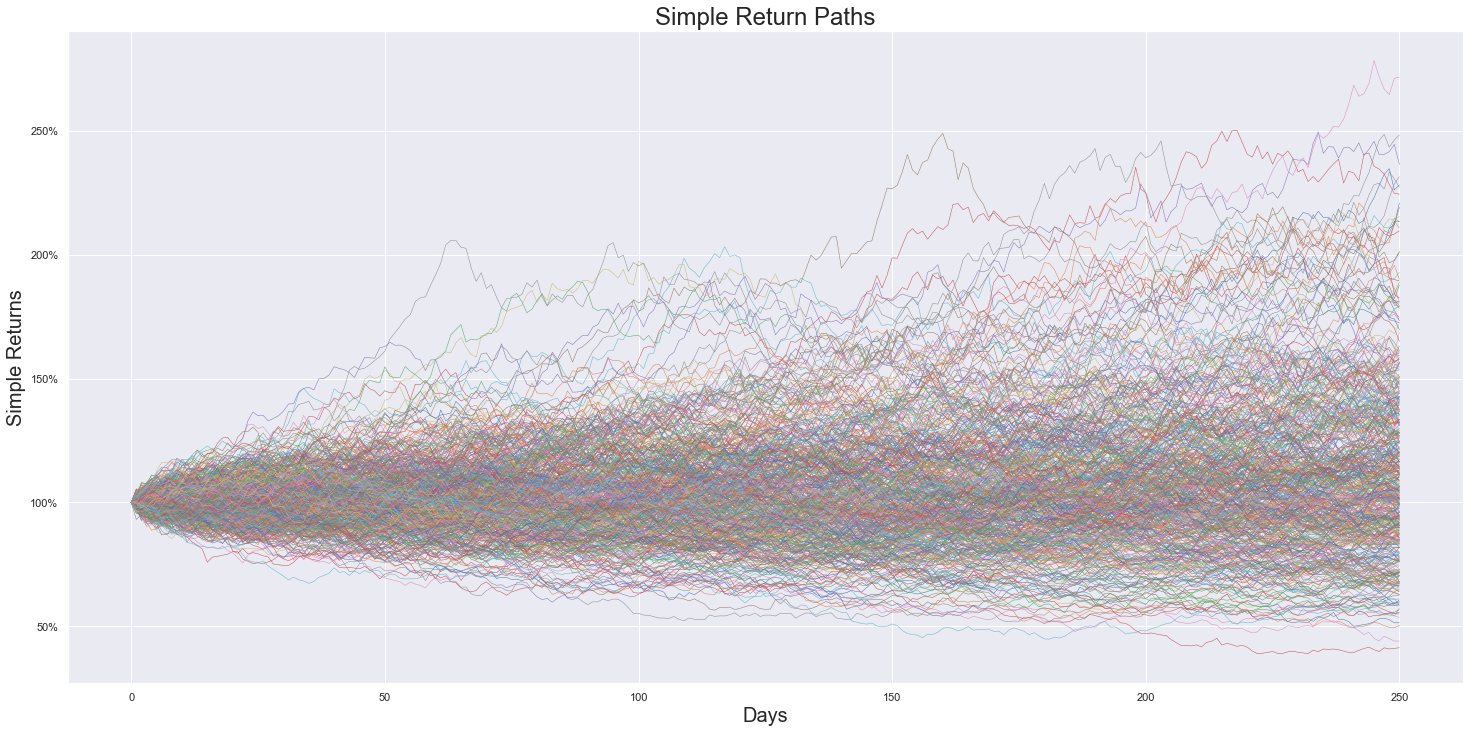

In [7]:
# define day count to sub-divide period
days = 250
paths = 100000
# define 10,000 paths of 250 steps
norm_draws = [rng.normal(size=days) for x in range(paths)]

# define our daily simple returns
daily_simp_rets = [1 + r/days + sigma/(days**0.5)*x for x in norm_draws]
# add in starting point to the return sequence
daily_simp_rets = [np.insert(x, 0, 1) for x in daily_simp_rets]
# compute our cumulative returns using cumprod as they are not additive
simple_rets = [np.cumprod(x) for x in daily_simp_rets]

fig, ax = plt.subplots(figsize=(25,12))

for p in simple_rets[:500]:
    ax.plot([z for z in range(0, days+1)], p, linewidth=0.5)

ax.set_title('Simple Return Paths', fontsize=24)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Simple Returns', fontsize=20)
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()]);

What can we see here:
 - the paths have a distribution to them - most paths end in the middle with some wild ones on each extreme
 - overall the distribution looks slightly skewed upwards: there are some paths with more than +100% but few below -50%

Let's plot the distributions now of final prices and the distribution of their **_simple_** returns

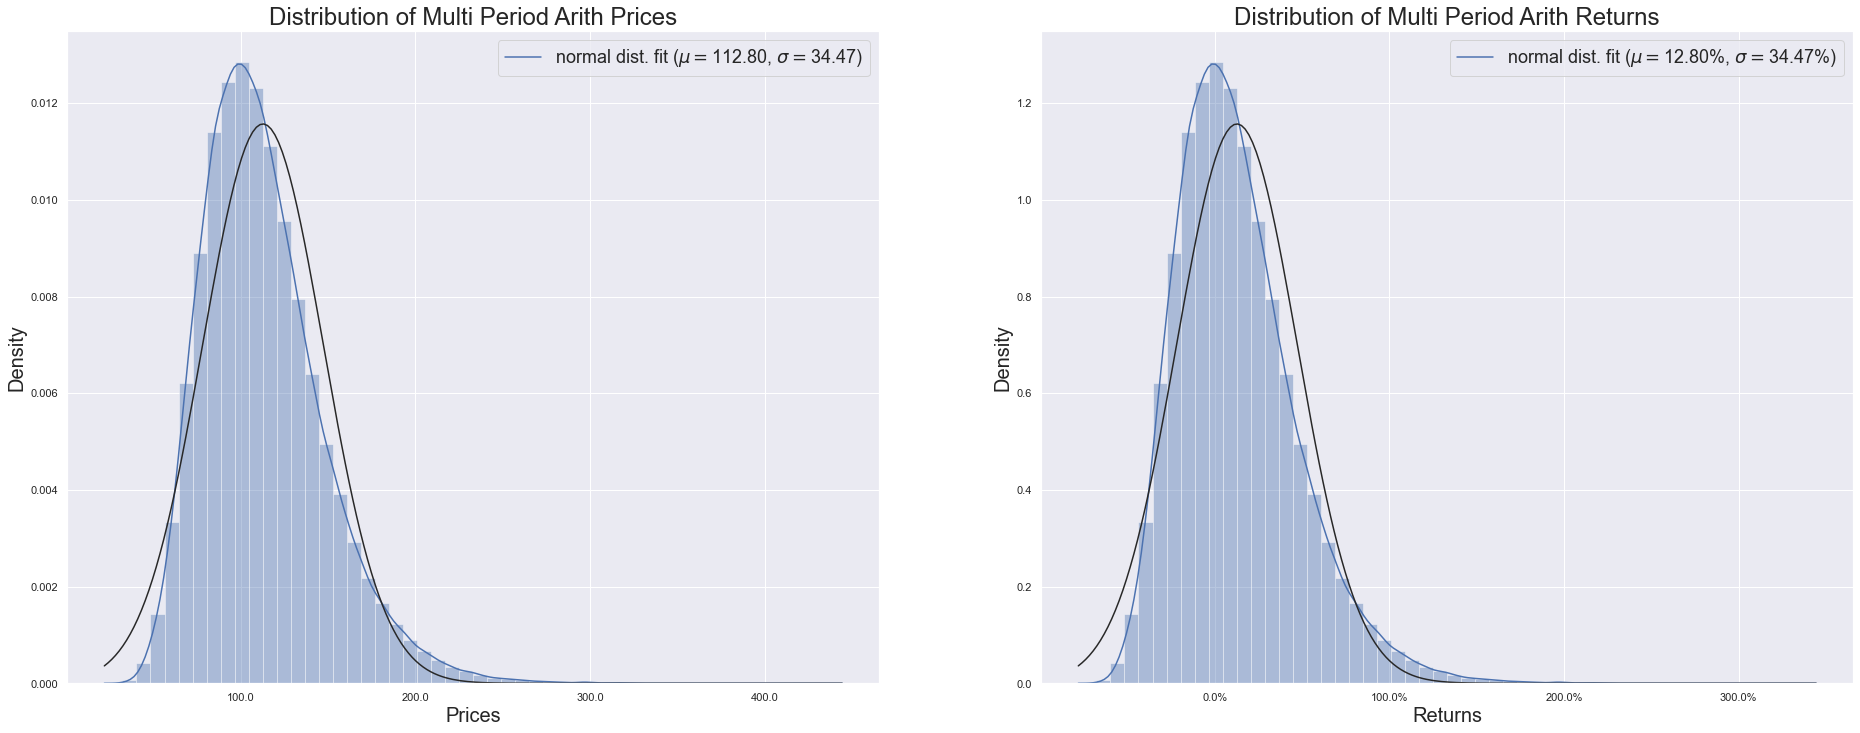

In [8]:
simp_multi_period_prices = [s0*x for x in simple_rets]
simp_multi_period_rets = [x[-1]/s0 - 1 for x in simp_multi_period_prices]

# plot the distribution of final prices
# create the figure
fig, ax = plt.subplots(ncols=2, figsize=(32,12))

# fit a dist plot
sns.distplot([x[-1] for x in simp_multi_period_prices], fit=stats.norm, ax=ax[0]);
sns.distplot(simp_multi_period_rets, fit=stats.norm, ax=ax[1]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit([x[-1] for x in simp_multi_period_prices])
ax[0].set_title('Distribution of Multi Period Arith Prices', fontsize=24)
ax[0].set_xlabel('Prices', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2f}, $\sigma=${1:,.2f})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(simp_multi_period_rets)
ax[1].set_title('Distribution of Multi Period Arith Returns', fontsize=24)
ax[1].set_xlabel('Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

So we have a mean where we would expect - around `exp(0.12)` - but the distribution looks off as we have:
 - greater than 30% standard deviation
 - a skewed distribution of prices and simple returns

Why is this the case? For that, let's look back at what happened in the non-random case when we made the periods smaller and more frequent.

## Compounding with uncertainty

So when we had the non-random case, we found that splitting time into smaller and smaller chunks resulted in a higher (because we assumed a positive deterministic return) overall return due to compounding and that this approached the exponential function. With uncertainty, we have the following phenomenon:
 - if we have a path made of 10 steps with either +10% or -10% return (not a normal distribution, one or the other - either +10% or -10%)
 - there will be some paths with either all 10 steps as +10%, and some with all 10 steps -10%
 - these finishing prices will be either:
   - 100 * 1.1^10 = 259.37 -> simple return 159.37%
   - 100 * 0.9^10 = 34.87 -> simple return -65.13%
 - clearly the upside compounding results in a closing price much further away from the start than the negative compounding

The above gives some intuition as to why when we have uncertainty we end up with this skewed distribution. The majority of paths will bumble around the middle (up, down, up, down) but there will be some that consistently compound in the same direction with the upside compounding more (in simple returns) away than the downside.

## Logarithmic returns with randomness

Let's now do the counterpart to what we did with non-random returns and have a look at this limit case where we divide time into infinitely small chunks. We define our logarithmic return for a period `t` as:

$$ r_t = ln(\frac{S_t}{S_{t-1}}) = \frac{r}{T} + \frac{\sigma}{\sqrt{T}} \epsilon_t \ \ \ , \epsilon_t \sim N(0,1) $$

In other words, just like simple returns we define it as a deterministic bit of return, `r`, and some random bit which for now is assumed to be normally distributed and scaled by our chosen amount of variation, sigma. How does this look if we draw 10,000 samples?

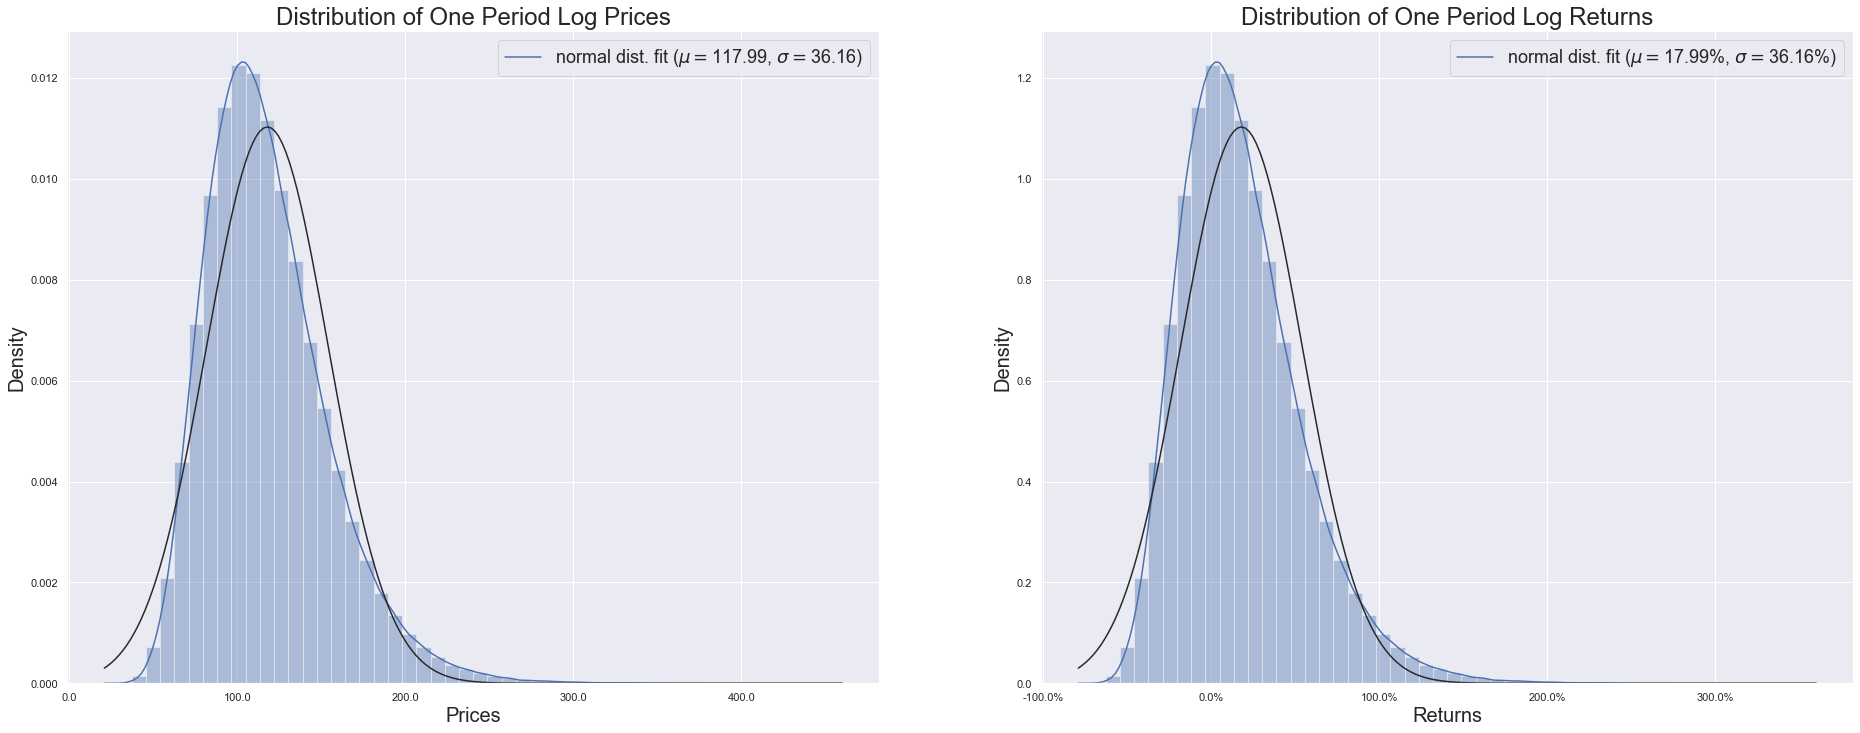

In [9]:
# set starting stock price, retun, std dev and days per year
s0 = 100
r = 0.12
sigma = 0.30
paths = 500000

# draw random numbers form std normal dist
norm_draws = rng.normal(size=paths)

log_one_period_prices = [s0 * np.exp(r + x*sigma) for x in norm_draws]
log_one_period_rets = [(x - s0)/s0 for x in log_one_period_prices]
log_one_period_rets_ln = [np.log(x/s0) for x in log_one_period_prices]

# plot the distribution of final prices
# create the figure
fig, ax = plt.subplots(ncols=2, figsize=(32,12))

# fit a dist plot
sns.distplot(log_one_period_prices, fit=stats.norm, ax=ax[0]);
sns.distplot(log_one_period_rets, fit=stats.norm, ax=ax[1]);
# sns.distplot(log_one_period_rets_ln, fit=stats.norm, ax=ax[2]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_one_period_prices)
ax[0].set_title('Distribution of One Period Log Prices', fontsize=24)
ax[0].set_xlabel('Prices', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2f}, $\sigma=${1:,.2f})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_one_period_rets)
ax[1].set_title('Distribution of One Period Log Returns', fontsize=24)
ax[1].set_xlabel('Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

So again we don't have the symmetric distribution here. We also have:
 - a mean ending price of `117.98` and hence simple return of 17.98% (whilst we inputted 12.00%)
 - a standard deviation of simple returns of 36.15% when we inputted 30.00%

We seem to be building up a load of questions here so time to get into the stats to answer them.

## What do we 'expect' the mean simple return to be when we model with log returns?

In other words - if we build our stock price series using log returns but then compute the simple return after we have built it - what do we expect this to be? Let's take the above model for returns as logarithmic again over a whole period (so we remove the T's from the equation):

$$ ln(\frac{S_T}{S_{0}}) = r + \sigma \epsilon_t, \ \ \ \epsilon_t \sim N(0,1) $$

Now let's rearrange so we have it in terms of price, `S`, and then define simple return:

$$
\begin{align}
S_T &= S_0 e^{r + \sigma \epsilon_t} \\
\frac{S_T - S_0}{S_0} &= e^{r + \sigma \epsilon_t} - 1 \\
\end{align}
$$

Let's also now re-define our random component to instead of having a mean and variance of 0 and 1, to represent our return, `r`, and standard deviation sigma:

$$ \frac{S_T - S_0}{S_0} = e^{\epsilon_t} - 1 \ \ \ , \epsilon_t \sim N(r, \sigma^2) $$

Now from the above we were implicitly expecting the following:

$$
\begin{align}
E(\frac{S_T - S_0}{S_0}) &= E(e^{\epsilon_t} - 1) \\
                         &= E(e^{\epsilon_t}) - 1 \\
                         &= 1.12 - 1 = 12.00\%
\end{align}
$$

which clearly isn't true. So where are we going wrong? __Inside that expectation operator.__

## So what should it be?

Now it's time to get into the stats and tease out the relationship between log and simple returns. Let's set up the problem formally then tear through it to reveal why we seem to have this discrepancy between the distributional properties of the simple returns when we build the simulations using log returns vs what we input into the model.

Let's define `X` as this quantity we care about:

$$ X = e^{\epsilon_t}, \ \ \  \epsilon_t \sim N(\mu, \sigma^2) $$

What is the expectation of `X`? Given that `X` is now the definition of a log-normally distributed variable we know that the probability that `X` at any point is equal to a certain value `x` is:

$$ f(X=x) = \frac{1}{x \sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \frac{(ln(x) - \mu)^2}{\sigma^2}} $$

So for us to take the expectation of this we have the following - the value of each `X` multiplied by it's probability of happening:

$$
\begin{align}
E(X) &= \int_{-\infty}^{\infty} x f(x) dx \\
     &= \int_{-\infty}^{\infty} x \frac{1}{x \sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \frac{(ln(x) - \mu)^2}{\sigma^2}} dx
\end{align}
$$

which we can:
 - cancel those `x`'s at the start
 - change the bounds on as the log normal has no probability below zero (so start integral at zero)
 - chuck some constants outside the expectation operator

$$
\begin{align}
E(X) &= \int_{-\infty}^{\infty} x \frac{1}{x \sigma \sqrt{2 \pi}} e^{-\frac{1}{2} \frac{(ln(x) - \mu)^2}{\sigma^2}} dx \\
     &= \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-\frac{1}{2} \frac{(ln(x) - \mu)^2}{\sigma^2}} dx
\end{align}
$$

Now let's do something a little clever to simplify this a bit. Let's make a 'change of variables' so that it becomes easier to simplify down. Let's restate the following:

$$ y = \frac{ln(x) - \mu}{\sigma} $$

which means we then also have the following:

$$
x = e^{\mu + y \sigma} \\
dx = \sigma e^{\mu + \sigma y} dy \\
$$

which now means we can substitute all these things in and get the following:

$$ E(X) = \frac{1}{\sigma \sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-\frac{1}{2} y^2} \sigma e^{\mu + \sigma y} dy $$

Now we can:
 - cancel the sigmas outside of any exponents
 - re-arrange our terms in the exponents so that we can collapse one to be a square

$$ E(X) = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{\infty} e^{-\frac{1}{2} (y^2 - 2 \sigma y + \sigma^2)} e^{\mu + \frac{1}{2} \sigma^2} dy $$

And now we rearrange once more:
 - pull that last bit out as it does not depend on y and so is constant in this integral
 - put the start bit back inside the integral (for aesthetics to see how it collapses)
 - collapse the middle exponent so the square is outside the brackets

$$ E(X) = e^{\mu + \frac{1}{2} \sigma^2} \int_{-\infty}^{\infty} \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} (y - \sigma)^2} dy $$

Now what have we got left inside our integral? We have the formula for a Normal Distribution CDF with:
   - mean of `sigma`
   - variance of `1`

which means it has an integral of 1 which gives us our final answer of:

$$ E(X) = e^{\mu + \frac{1}{2} \sigma^2} $$

## Right, so how does this tie back into our discrepancies?

So we have just proved that, in theory, the following should hold:

$$
\begin{align}
E(X) &= E(\frac{S_T - S_0}{S_0}) \\
     &= E(e^{r + \sigma \epsilon_t}) - 1 \\
     &= e^{r + \frac{1}{2} \sigma^2} - 1
\end{align}
$$

So what does this give us - well it turns out that `100` * `exp(0.12 + 0.5 * 0.3^2)` = `117.94%` which is almost exactly what we get above in our simulations as our mean.

## Okay so we can line up - but why? What's the intuition behind the return being higher?

__Compounding__. Once again the answer lies in compounding - this time embedded in the exponential function. As we showed earlier, the distribution changes shape when we start to sub-divide our returns into smaller chunks with uncertainty. We get paths that are further away on the upside from our initial price than downside. The exact same thing is happening here due to the shape of the exponential function. We can see this graphically if we plot a given simple return vs the corresponding log return we would get.

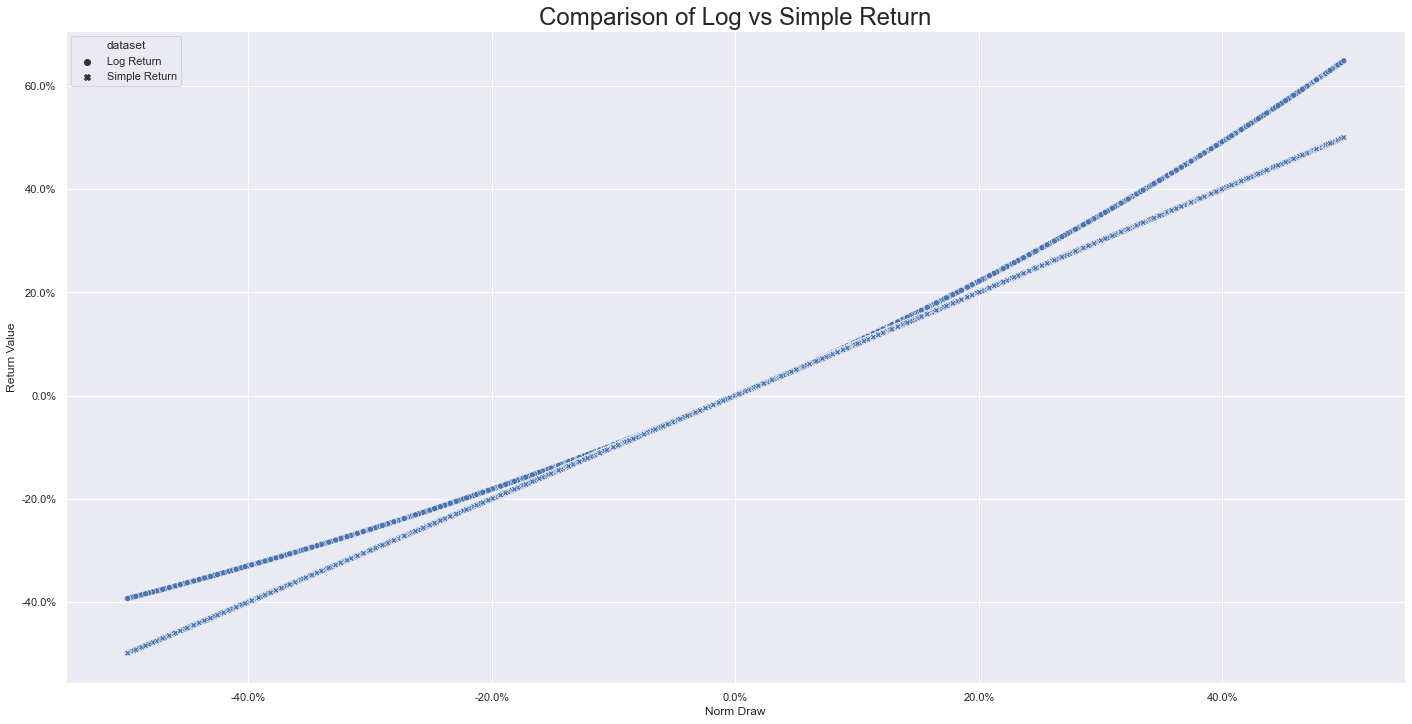

In [10]:
# get draws from norm dist that are small
norm_draws = rng.normal(size=paths)
sample_draws = [x for x in norm_draws if abs(x) < 0.5][:10000]

# convert to dataframe
log_draws = pd.DataFrame({'Norm Draw': sample_draws, 'Return Value': [np.exp(x)-1 for x in sample_draws]})
simple_draws = pd.DataFrame({'Norm Draw': sample_draws, 'Return Value': sample_draws})
all_draws = pd.concat([log_draws.assign(dataset='Log Return'), simple_draws.assign(dataset='Simple Return')])

# plot
fig, ax = plt.subplots(figsize=(24, 12))

sns.scatterplot(data=all_draws, x='Norm Draw', y='Return Value', style='dataset')
ax.set_title('Comparison of Log vs Simple Return', fontsize=24)
ax.set_xticklabels(['{:,.1%}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['{:,.1%}'.format(x) for x in ax.get_yticks()]);

In other words:
 - every time we get a positive random fluctuation, the exponential function makes it larger
 - every time we get a negative random fluctuation, the exponential function makes it smaller

So when we average these we don't get zero as the positive fluctuations have been magnified and the negative diminished. It also makes sense that the larger the deviations the larger the difference in this mean as the difference between the two lines increases with larger moves.

## Can we plot this relationship so we can visualise the difference increasing with higher variances?

Yes - to make sure this is absolutely clear, let's do the following:
 - for a given variance draw a load of numbers from a normal distribution
 - using those numbers:
   - compute closing prices using simple returns
   - compute closing prices using log returns
 - compute the mean simple return and mean log return of these prices
 - difference these means
 - compare this difference to the difference we would 'expect' based on the above 'variance adjustment' i.e. the log numbers should be higher due to this exponential effect on the random component
 - repeat this for a range of variances and also larger numbers of simulations to ensure that the Law of Large Numbers (LLN) holds and we converge to the theoretical expectation

Bit of a mouthful all that but the pretty graphs should make it clear.

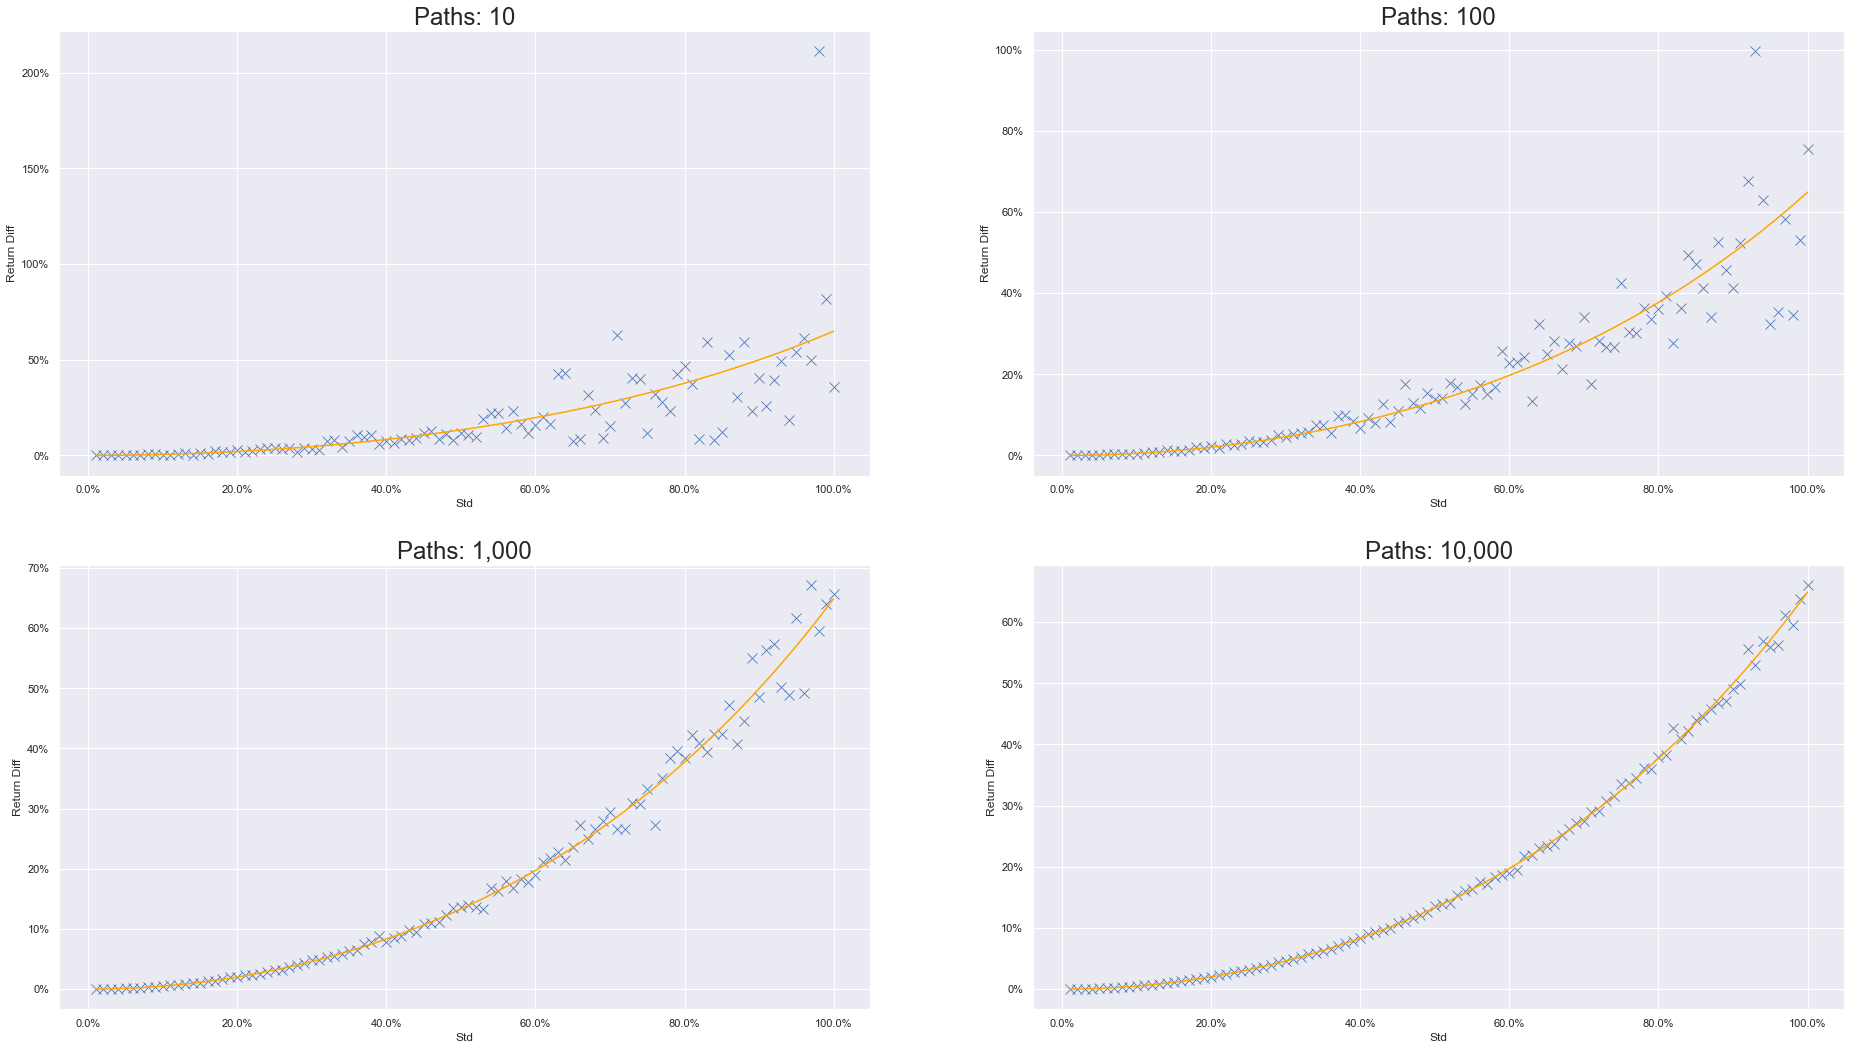

In [23]:
r = 0.00
path_list = [10, 100, 1000, 10000]
std_devs = np.linspace(0.01, 1, 100)

path_rets = {}
# for each set of paths
for p in path_list:
    ret_diff = []
    for v in std_devs:
        # draw from normal dist
        draws = rng.normal(size=p)
        # compute arithmetic process returns
        arith = [r + v*x for x in draws]
        # compute geo process returns
        geo = [np.exp(r + v*x) - 1 for x in draws]
        # compute mean returns
        arith_mean = np.mean(arith)
        geo_mean = np.mean(geo)
        ret_diff.append({'Return Diff': geo_mean - arith_mean, 'Std Dev': np.std(arith), 'Geo Mean': geo_mean, 'Arith Mean': arith_mean, 'Std': v})
    path_rets[p] = pd.DataFrame(ret_diff)
    
# plot our 2x2 grid and reshape the axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(32,18))
axes = axes.reshape(-1)

for p, rets in path_rets.items():
    # sort rets
    rets = rets.sort_values('Std Dev')
    # get ax
    ax = axes[list(path_rets.keys()).index(p)]
    # plot our return differences
    sns.scatterplot(data=rets, x='Std', y='Return Diff', ax=ax, marker='x', s=100)
    # compute theoretical line
    ret_adj = [0.5 * x**2 for x in std_devs]
    ax.plot(std_devs, [np.exp(0.5 * x**2)-1 for x in std_devs], color='orange')
    ax.set_title('Paths: {:,.0f}'.format(p), fontsize=24)
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
    ax.set_xticklabels(['{:,.1%}'.format(x) for x in ax.get_xticks()])

So it looks like we're lining up:
 - there is more noise in the small sample paths but Law of Large Numbers starts to pull through well
 - interestingly there is more noise at higher levels of variance
 - the difference between mean logarithmic return and mean simple return lines up with what we proved theoretically

Great!!! We now have a model that incorporates randomness and we understand how it generates the returns it does!

## Multi Period Log Returns with randomness

So all that's left is to see if we can extend our log return model to have multiple periods (as well as randomness) and see if this impacts anything. Let's look at how we can define a multi-period return using a combination of single period returns:

$$
\begin{align}
ln(\frac{S_T}{S_0}) &= ln(\frac{S_T}{S_{T-1}}) + ln(\frac{S_{T-1}}{S_{T-2}}) + \ldots + ln(\frac{S_{1}}{S_{0}}) \\
                    &= [\frac{r}{T} + \frac{\sigma}{\sqrt{T}} \epsilon_{T-1}] + [\frac{r}{T} + \frac{\sigma}{\sqrt{T}} \epsilon_{T-2}] + \ldots + [\frac{r}{T} + \frac{\sigma}{\sqrt{T}} \epsilon_{0}] \\
                    &= \sum_{t=0}^{T-1} \frac{r}{T} + \frac{\sigma}{\sqrt{T}} \sum_{t=0}^{T-1} \epsilon_t \\
                    &= r + \frac{\sigma}{\sqrt{T}} \sum_{t=0}^{T-1} \epsilon_t
\end{align}
$$

so through re-arranging we can see that we can make our logarithmic returns additive. We can then exponentiate to get our final prices then compute our simple returns based on that.

$$
\begin{align}
S_T &= S_0 e^{r + \frac{\sigma}{\sqrt{T}} \sum_{t=0}^{T-1} \epsilon_t} \\
    &= S_0 e^{r} e^{\frac{\sigma}{\sqrt{T}} \sum_{t=0}^{T-1} \epsilon_t} \\
\end{align}
$$

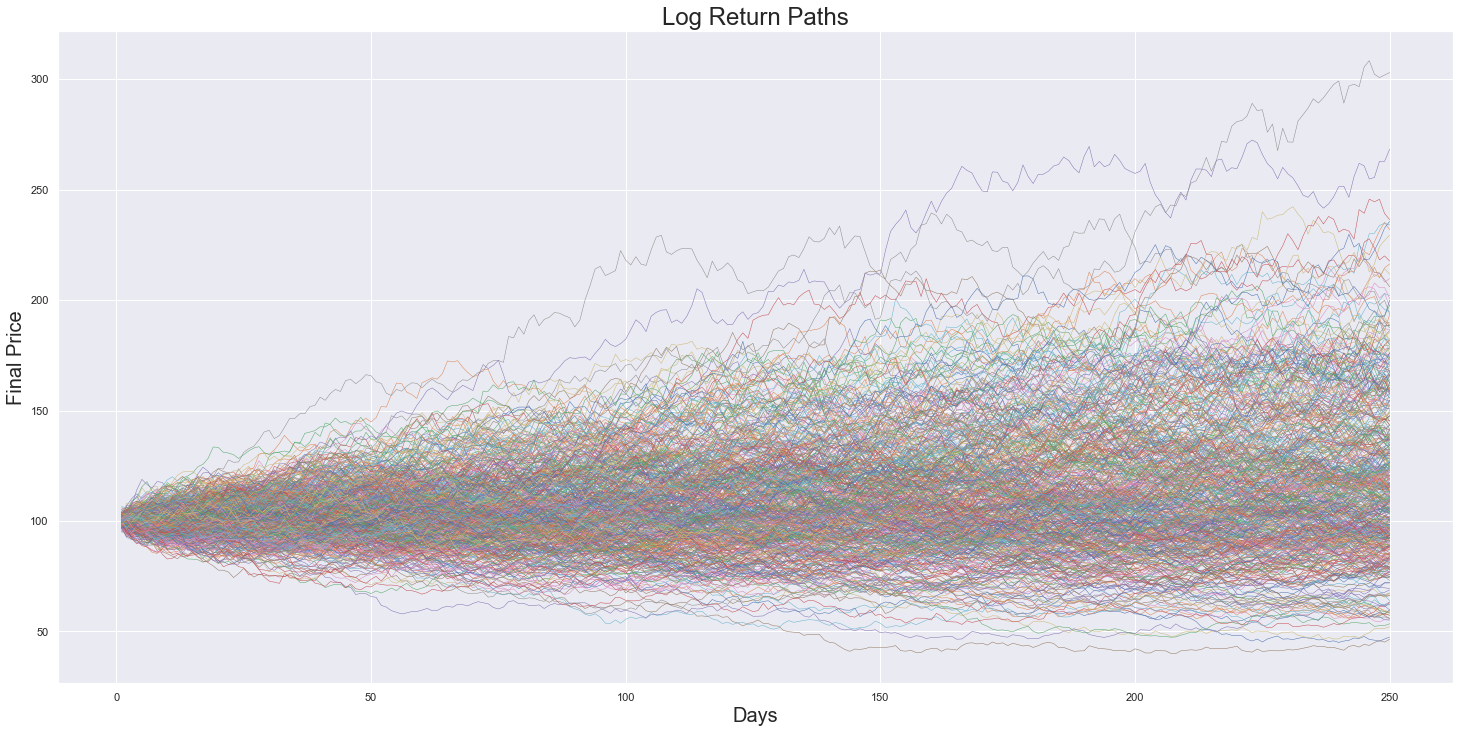

In [12]:
# define our setup
r = 0.12
sigma = 0.30
paths = 100000
days = 250

norm_draws = [rng.normal(size=days) for x in range(paths)]

# define our returns
daily_log_rets = [r/days + sigma/(days**0.5) * x for x in norm_draws]
# define cum log returns by adding
log_rets = [np.cumsum(x) for x in daily_log_rets]
# exponentiate and multiply by s0 to get price series
log_prices = s0*np.exp(log_rets)

fig, ax = plt.subplots(figsize=(25,12))

for p in log_prices[:500]:
    ax.plot([z for z in range(1, days+1)], p, linewidth=0.5)
    
ax.set_title('Log Return Paths', fontsize=24)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Final Price', fontsize=20);
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()]);

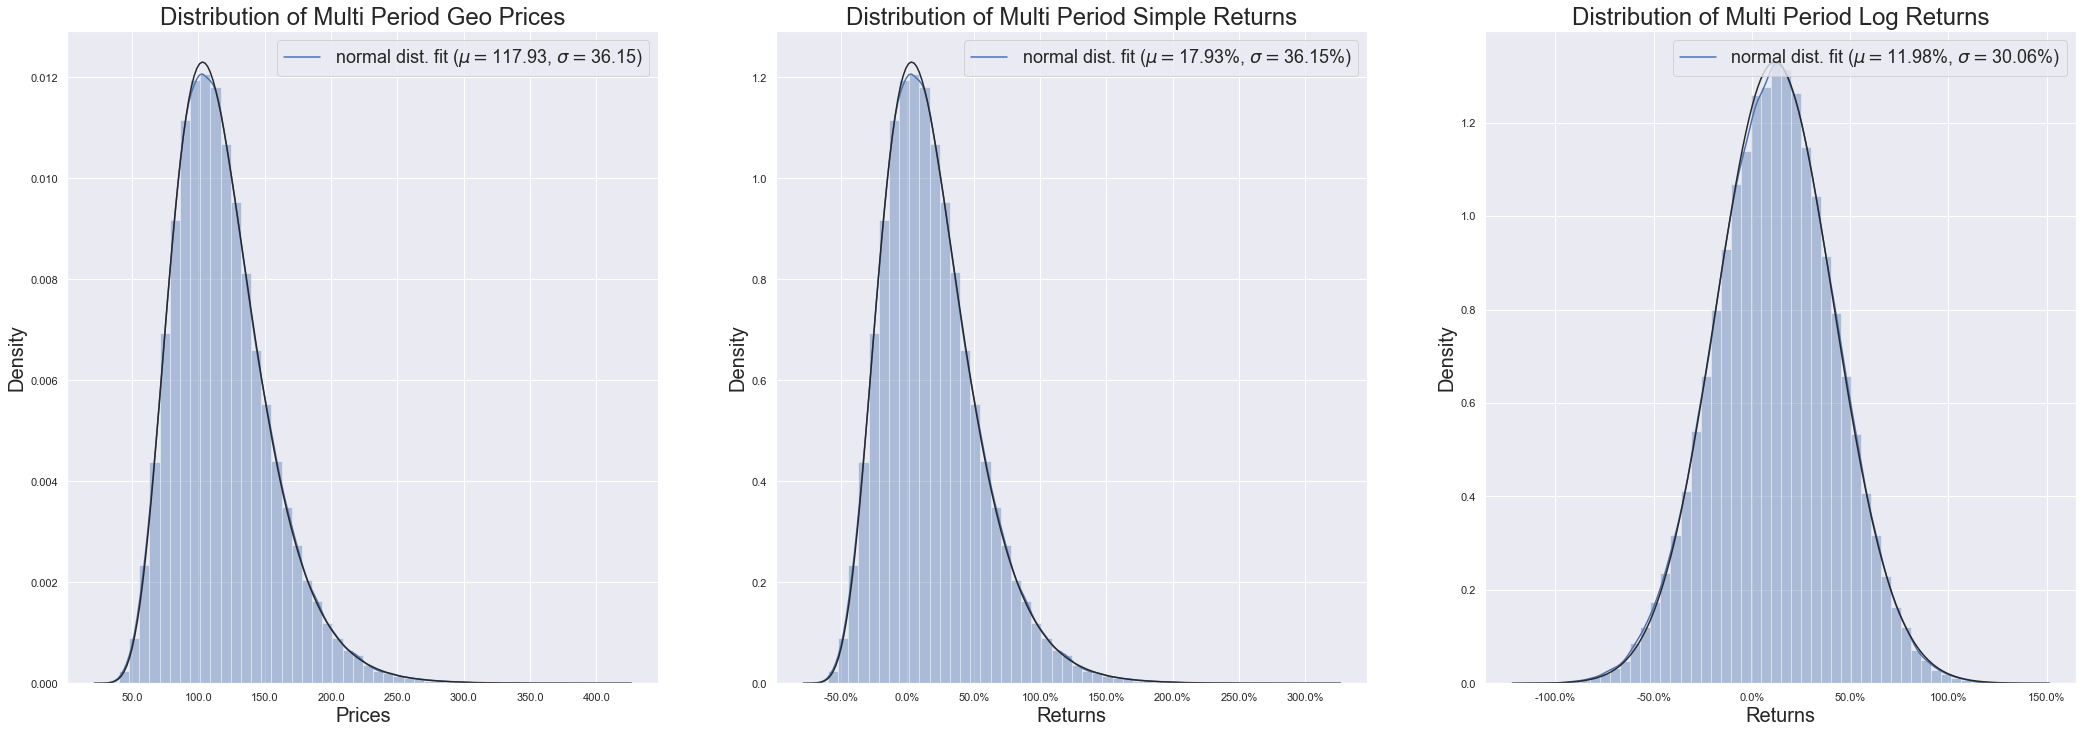

In [13]:
log_multi_period_prices = [x[-1] for x in log_prices]
log_multi_period_rets = [x/s0 - 1 for x in log_multi_period_prices]
log_multi_period_rets_log = [np.log(x/s0) for x in log_multi_period_prices]

# plot the distribution of final prices
# create the figure
fig, ax = plt.subplots(ncols=3, figsize=(36,12))

# fit a dist plot
sns.distplot(log_multi_period_prices, fit=stats.lognorm, ax=ax[0]);
sns.distplot(log_multi_period_rets, fit=stats.lognorm, ax=ax[1]);
sns.distplot(log_multi_period_rets_log, fit=stats.lognorm, ax=ax[2]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_prices)
ax[0].set_title('Distribution of Multi Period Geo Prices', fontsize=24)
ax[0].set_xlabel('Prices', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2f}, $\sigma=${1:,.2f})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_rets)
ax[1].set_title('Distribution of Multi Period Simple Returns', fontsize=24)
ax[1].set_xlabel('Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_rets_log)
ax[2].set_title('Distribution of Multi Period Log Returns', fontsize=24)
ax[2].set_xlabel('Returns', fontsize=20)
ax[2].set_ylabel('Density', fontsize=20)
ax[2].set_xticklabels(['{:,.1%}'.format(x) for x in ax[2].get_xticks()]);
ax[2].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

## What about the variance? Why is it larger for log returns than in our simple return model?

Again this boils down to how we are computing our standard deviation. If we compute the standard deviation of the log returns then it will exactly equal 30.00% - as we can see in the right-most chart above. However if we compute the simple returns, after having modelled our price series using log returns, then we get a different (larger) standard deviation.

Why? This isn't exactly a full proof answer but for the same reason as our mean return is higher - higher mean simple returns will mean higher deviation of simple returns to achieve that. It's not exact but:
 - if we look at our ratio of simple returns i.e. `18%/12%` = `1.5x`
 - multiply our variance by this amount i.e. `30^2 * 1.5` = `0.135`
 - compute the standard deviation i.e. `sqrt(0.135)` = `~36.75%`

which roughly is the standard deviation of our simple returns above of 36.10%. Mathematically, the two are actually linked by this formula:

$$ Var(r) = [e^{\sigma^2} - 1] * [e^{2r + \sigma^2}] $$

which when computed gives us exactly 36.20% which is approx we have above.

## Recap

So what have we established?
 - the desire to have time-increment homogenous returns and non-negative prices naturally brings us to log returns
 - when we simulate using log returns but then calculate the simple return of each simulated path, we end up with a higher return and variance than we entered into the simulation
 - this is because of the compounding effect of the exponential function when applied to random deviations

with the implication being that __we need to be very careful when talking about return - calibrating a stock price simulator built using log returns to a simple return number will give us the wrong distribution of final prices.__

## An example perhaps?

Let's take the example of the SPX and use that data to calibrate some simulations.

In [14]:
# read in spx time series
df_spx = pd.read_csv('~/dev/dolla/notebooks/asset_data.csv', index_col='Date', parse_dates=['Date'])[['SPX']]
# define simple and log returns
df_spx['simple'] = df_spx['SPX'] / df_spx['SPX'].shift(1) - 1
df_spx['log'] = np.log(df_spx['SPX'] / df_spx['SPX'].shift(1))
# drop na and show tail
df_spx = df_spx.dropna()
df_spx.tail()

,SPX,simple,log
Date,,,
2021-09-27,4443.109863,-0.002776,-0.002780
2021-09-28,4352.629883,-0.020364,-0.020574
2021-09-29,4359.459961,0.001569,0.001568
2021-09-30,4307.540039,-0.011910,-0.011981
2021-10-01,4357.040039,0.011491,0.011426


So we have our dataframe of spx returns - both simple and log. Let's plot their respective distributions:

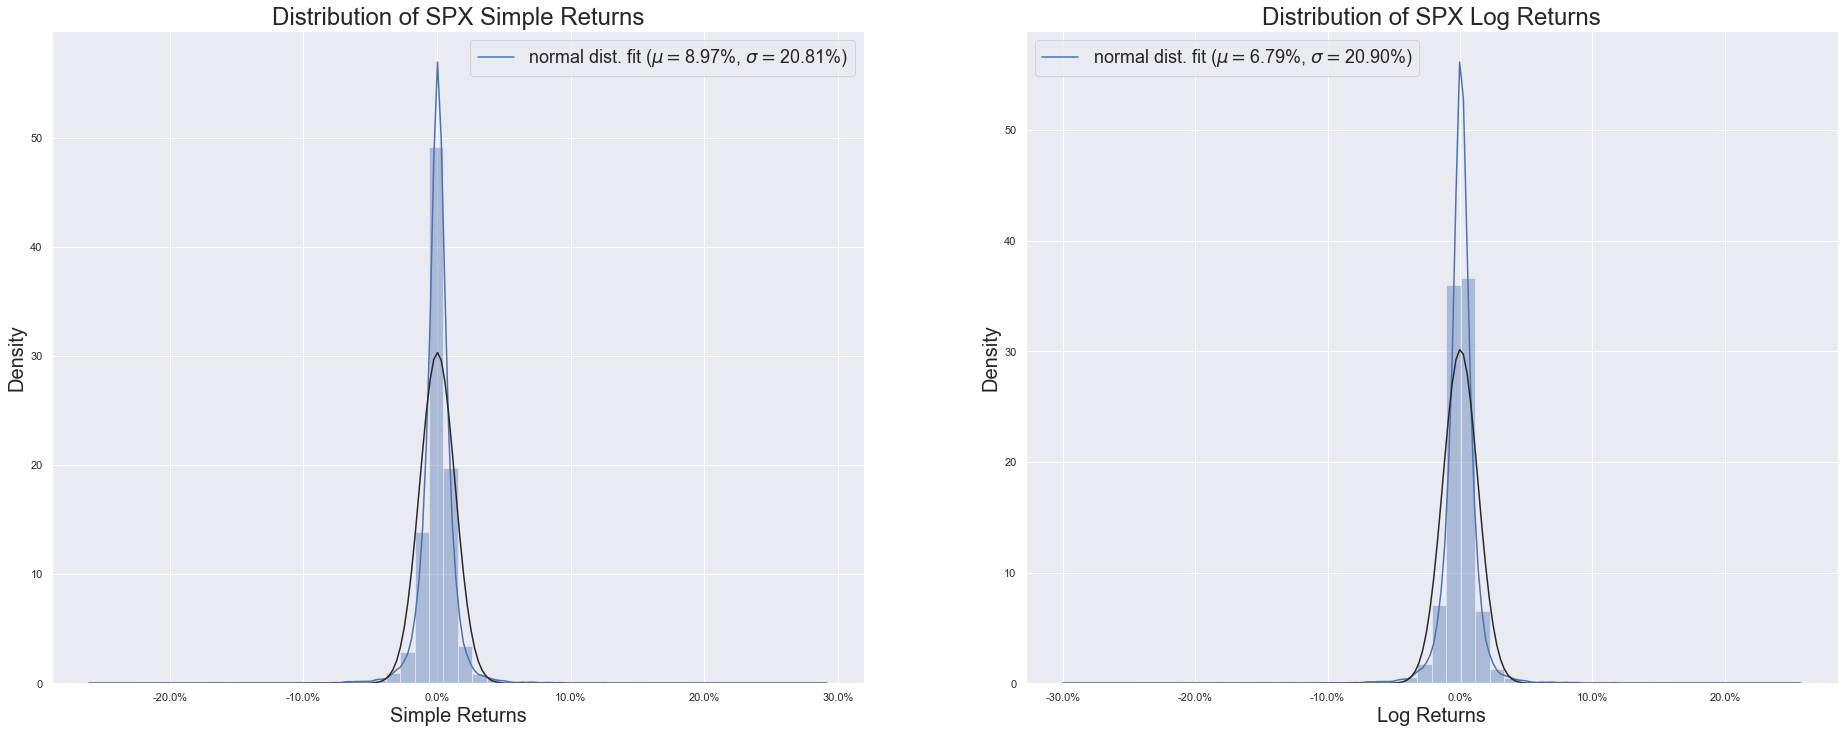

In [15]:
# plot the distribution of returns
# create the figure
fig, ax = plt.subplots(ncols=2, figsize=(32,12))

# fit a dist plot
sns.distplot(df_spx['simple'], fit=stats.norm, ax=ax[0]);
sns.distplot(df_spx['log'], fit=stats.norm, ax=ax[1]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(df_spx['simple'])
ax[0].set_title('Distribution of SPX Simple Returns', fontsize=24)
ax[0].set_xlabel('Simple Returns', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1%}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu*days, s*np.sqrt(days))], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(df_spx['log'])
ax[1].set_title('Distribution of SPX Log Returns', fontsize=24)
ax[1].set_xlabel('Log Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu*days, s*np.sqrt(days))], fontsize=18);

So we have the following:
 - SPX daily returns clearly not normal but let's glance over that for now
 - SPX has a mean daily (annualised) simple return of 9.00% and standard deviation of around 21.00%

Let's use these numbers (instead of the correct log return numbers) to calibrate our simulations.

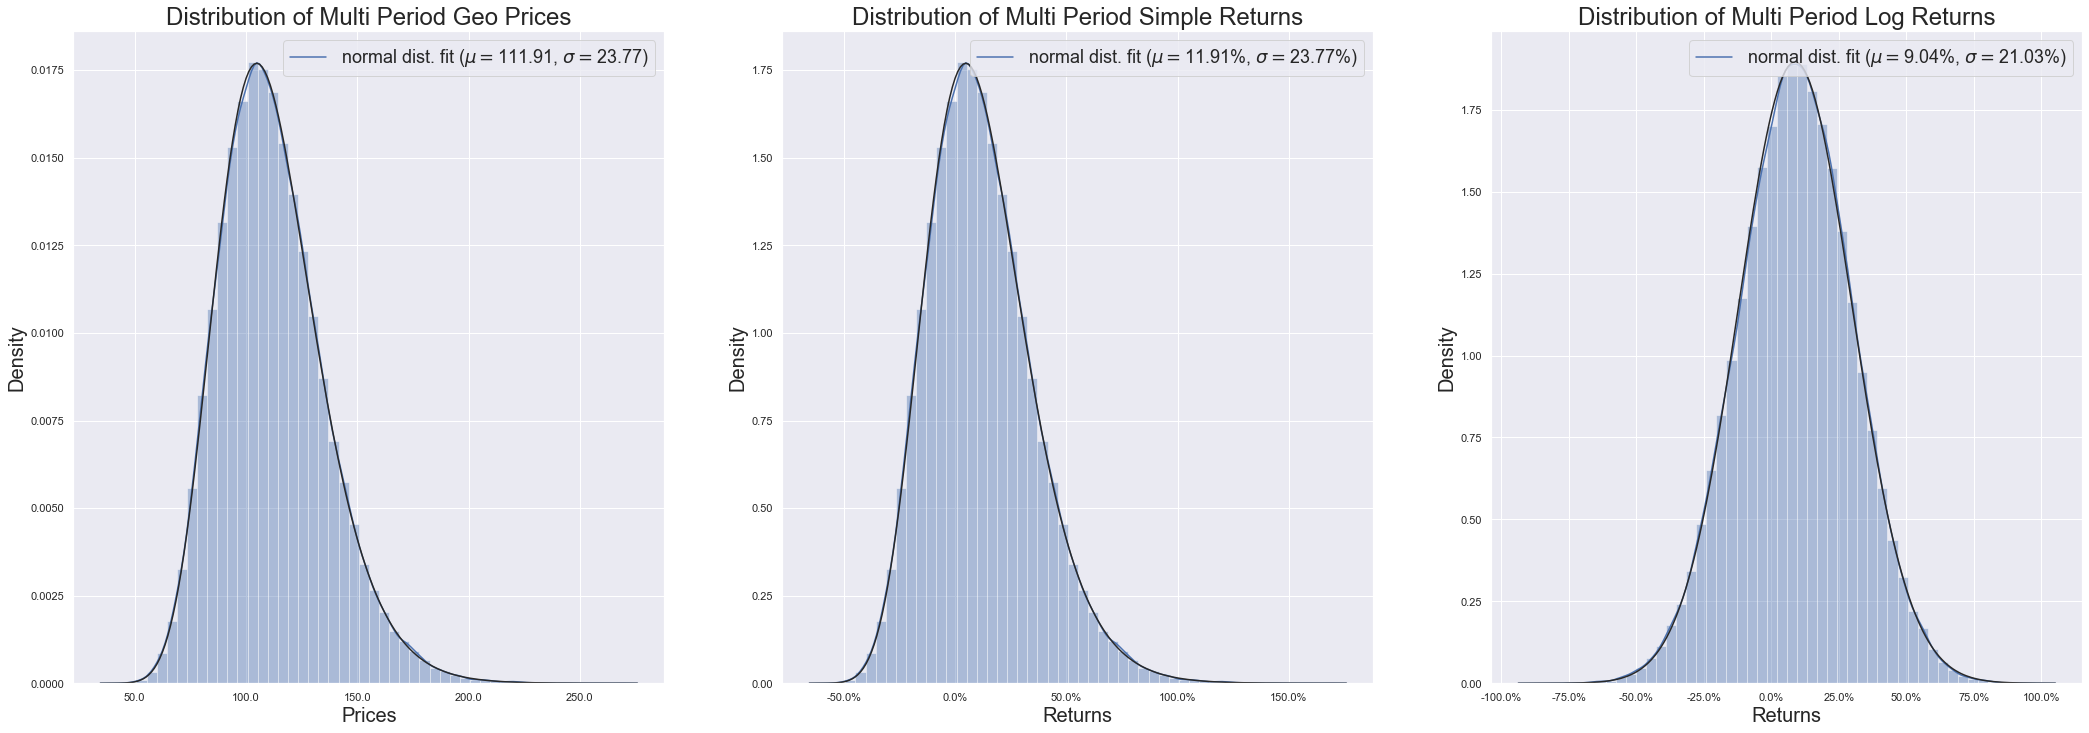

In [16]:
# define our setup
r = 0.09
sigma = 0.21
paths = 100000
days = 250

norm_draws = [rng.normal(size=days) for x in range(paths)]

# define our returns
daily_log_rets = [r/days + sigma/(days**0.5) * x for x in norm_draws]
# define cum log returns by adding
log_rets = [np.cumsum(x) for x in daily_log_rets]
# exponentiate and multiply by s0 to get price series
log_prices = s0*np.exp(log_rets)

log_multi_period_prices = [x[-1] for x in log_prices]
log_multi_period_rets = [x/s0 - 1 for x in log_multi_period_prices]
log_multi_period_rets_log = [np.log(x/s0) for x in log_multi_period_prices]

# plot the distribution of final prices
# create the figure
fig, ax = plt.subplots(ncols=3, figsize=(36,12))

# fit a dist plot
sns.distplot(log_multi_period_prices, fit=stats.lognorm, ax=ax[0]);
sns.distplot(log_multi_period_rets, fit=stats.lognorm, ax=ax[1]);
sns.distplot(log_multi_period_rets_log, fit=stats.lognorm, ax=ax[2]);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_prices)
ax[0].set_title('Distribution of Multi Period Geo Prices', fontsize=24)
ax[0].set_xlabel('Prices', fontsize=20)
ax[0].set_ylabel('Density', fontsize=20)
ax[0].set_xticklabels(['{:,.1f}'.format(x) for x in ax[0].get_xticks()]);
ax[0].legend(["normal dist. fit ($\mu=${0:,.2f}, $\sigma=${1:,.2f})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_rets)
ax[1].set_title('Distribution of Multi Period Simple Returns', fontsize=24)
ax[1].set_xlabel('Returns', fontsize=20)
ax[1].set_ylabel('Density', fontsize=20)
ax[1].set_xticklabels(['{:,.1%}'.format(x) for x in ax[1].get_xticks()]);
ax[1].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

# compute the params of the fitted normal curve
(mu, s) = stats.norm.fit(log_multi_period_rets_log)
ax[2].set_title('Distribution of Multi Period Log Returns', fontsize=24)
ax[2].set_xlabel('Returns', fontsize=20)
ax[2].set_ylabel('Density', fontsize=20)
ax[2].set_xticklabels(['{:,.1%}'.format(x) for x in ax[2].get_xticks()]);
ax[2].legend(["normal dist. fit ($\mu=${0:,.2%}, $\sigma=${1:,.2%})".format(mu, s)], fontsize=18);

So what have we done?
 - taken the simple return stats
 - calibrated our log-normal simulations with these simple return numbers as our inputs for `r` and `sigma`
 - computed our closing price simple returns outputted by the log-normal model

We can clearly see that we have data for the simple returns that does not match what we desired - 9.00% with 21.00% volatility. The chart on the right shows that the model has done its job - as the log returns are exactly as inputted. __However this clearly shows the issue with mixing up the 2 different notions of return.__

## Concluding remarks

We've introduced the ideas of simple and log returns and shown how simulating stock returns under uncertainty leads to modelling logarithmic returns as the natural choice. In the above we have assumed that random deviations are normally distributed however this isn't necessary - we can extend this to model any calibrated distribution of returns whether that incorporates skew, kurtosis or even infinite variance processes where returns follow distributions from the Pareto family.